In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
import numpy as np
import cv2
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')

from ssd import build_ssd
%matplotlib inline
from matplotlib import pyplot as plt
import random
import os.path as osp
from utils.augmentations import SSDAugmentation

## Define class and matching index

In [2]:
#label_idx = {'valve': 4, 'backpack': 0, 'extinguisher': 1, 'toolbox': 3, 'radio': 2}
label_idx = {'missle': 0, 'backpack': 1, 'blueline': 2, 'drill': 3, 'can': 4}
label_idx = sorted(label_idx.items(), key=lambda kv: kv[1])
label = ['background']
for i in label_idx:
    label.append(i[0])
print(label)

['background', 'missle', 'backpack', 'blueline', 'drill', 'can']


In [3]:
net = build_ssd('test', 300, 6)    # initialize SSD, +1 for background
net.load_weights('/home/austin/SSD-SubT/weights/ncsisT/ncsisT.pth')

/home/austin/SSD-SubT/ssd.py:34: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  self.priors = Variable(self.priorbox.forward(), volatile=True)
/home/austin/SSD-SubT/layers/modules/l2norm.py:17: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  init.constant(self.weight,self.gamma)


Loading weights into state dict...
Finished!


## Build SSD300 Network

139
351.41608 262.1476 577.7879638671875 396.6329650878906
351.41608 262.1476 577.7879638671875 396.6329650878906
351.41608 262.1476 577.7879638671875 396.6329650878906
aaa


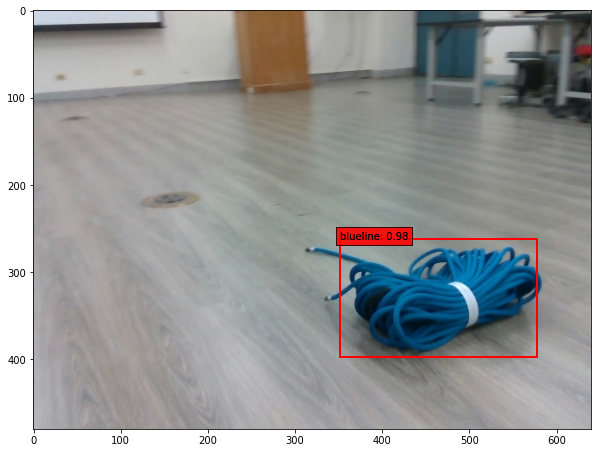

In [17]:
#warnings.filterwarnings( "ignore" )
IMAGE_ROOT = "/home/austin/DataSet/ncsist_dataset/ncsist/JPEGImages"
#img_list = os.listdir(IMAGE_ROOT)
test_file = '/home/austin/DataSet/ncsist_dataset/ncsist/ImageSets/Main/test.txt'
img_list = []
for line in open(osp.join(test_file)):
    img_list.append(line.strip())

img_id = random.randint(0, len(img_list)-1)
#img_path = IMAGE_ROOT + '/' + img_list[img_id]
img_path = IMAGE_ROOT + '/' + img_list[img_id] + '.jpg'
print(img_id)
image = cv2.imread(img_path)
#image = cv2.imread('/home/austin/DataSet/ncsist_dataset/ncsist/JPEGImages/backpack_8870.jpg')
rgb_image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
# View the sampled input image before transform
plt.figure(figsize=(10,10))
#plt.imshow(rgb_image)
#plt.show()

x = cv2.resize(image, (300, 300)).astype(np.float32)
x -= (104.0, 117.0, 123.0)
x = x.astype(np.float32)
x = x[:, :, ::-1].copy()
x = torch.from_numpy(x).permute(2, 0, 1)

xx = Variable(x.unsqueeze(0))# wrap tensor in Variable
#xx = torch.Tensor(x.unsqueeze(0).cuda())
if torch.cuda.is_available():
    xx = xx.cuda()
#warnings.filterwarnings( "ignore" )
y = net(xx)
#y = net.cuda()
currentAxis = plt.gca()
scale = torch.Tensor(rgb_image.shape[1::-1]).repeat(2)
detections = y.data # torch.Size([1, 4, 200, 5]) --> [batch?, class, object, coordinates]
objs = []
for i in range(detections.size(1)): # detections.size(1) --> class size
    for j in range(5): # each class choose top 5 predictions
        if detections[0, i, j, 0].cpu().numpy() > 0.5:
            score = detections[0, i, j, 0]
            pt = (detections[0, i, j,1:]*scale).cpu().numpy()
            objs.append([pt[0], pt[1], pt[2]-pt[0]+1, pt[3]-pt[1]+1, i, score])
    color_BBX = (255, 255, 0)
    color_TEXT = (255, 0, 0)
    colors = plt.cm.hsv(np.linspace(0, 1, 10)).tolist()
    for i, obj in enumerate(objs):
        #cv2.rectangle(rgb_image, (int(obj[0]), int(obj[1])),\
        #            (int(obj[0] + obj[2]), int(obj[1] + obj[3])), color_BBX, 3)
        #cv2.putText(rgb_image, label[obj[4]], (int(obj[0]), int(obj[1])), 0, 1, color_TEXT,2)
        coords = (obj[0], obj[1]), obj[2], obj[3]
        display_txt = '%s: %.2f'%(label[obj[4]], obj[5])
        print(obj[0], obj[1],obj[0] + obj[2],obj[1] + obj[3])
        currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=colors[i], linewidth=2))
        currentAxis.text(obj[0], obj[1], display_txt, bbox={'facecolor':colors[i], 'alpha':0.5})
print('aaa')
plt.imshow(rgb_image)